# Automated experiment

The following notebook is an example of how to set up an automated experiment. To run this notebook you need:

* Scenarios: A list of scenarios/conditions to run.
* Model(s): Passed in a list.

In the thesis we chose to use multiprocessing. This means that we can run multiple trials in parallel and greatly cut down on the execution time of the experiment. Care needs to be taken that all processes do not use the same seed and thus the same random numbers. This would effectively make the experiment invalid. On the other hand, different models need to be ran on the same seed to ensure that the results are valid. This is taken into account by us in the code: each process is responsible for a full trial and at the start of each trial (per process) a seed is generated to ensure that the results are valid.

parallelExperiment.py shows how to run the experiment in parallel.

In [2]:
from DataGenerator import TimeSeriesGenerator, suddenDrift, generateSeasonality, generateTrend
from conditions import scenarios
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler    
from grouped_series import ExperimentTracker    
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from TimeSeriesGradientBoosting import TimeSeriesGradientBoosting
from xgboost import XGBRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression

## Models

Xgboost is used as a representative for the non-linear models. 

Linear regression is used as a representative for the linear models. We use both a model that is updated online and a model that is not. Both are trained with stochastic gradient descent.

A hybrid model consisting of an online version of linear regression together with Xgboost. The switching happens on the basis of drift detection.

In [3]:
onehot1 = ColumnTransformer([('one_hot_encoder', OneHotEncoder(
), make_column_selector(dtype_include=object))], remainder=StandardScaler())

sgd_onehot_1 = ColumnTransformer([('one_hot_encoder', OneHotEncoder(
), make_column_selector(dtype_include=object))], remainder='passthrough')

onehot4 = ColumnTransformer([('one_hot_encoder', OneHotEncoder(
), make_column_selector(dtype_include=object))], remainder=StandardScaler())

hybrid_vars = [0,1, 2, 3, 4, 5, 6, 7, -3, -2, -1] 
# Regular Xgboost can be used instead, but this leads to better results. 
hybrid_model = TimeSeriesGradientBoosting(model1 = LinearRegression(), model2 = XGBRegressor(), model1_variables = hybrid_vars) 
hybrid_model2 = TimeSeriesGradientBoosting(model1 = LinearRegression(), model2 = XGBRegressor(), model1_variables = hybrid_vars)

hybrid_xgb_pipe = Pipeline([
    ('preprocessor', onehot1),
    ('regressor', hybrid_model)
])

hybrid_xgb_pipe2 = Pipeline([
    ('preprocessor', onehot4),
    ('regressor', hybrid_model2)
])


sgd_pipe_online = Pipeline([
    ('preprocessor', sgd_onehot_1),
    ('scaler', StandardScaler()),
    ('regressor', SGDRegressor())
])

switcher = [hybrid_xgb_pipe, sgd_pipe_online]

In [4]:
# Generates the data for the experiment and subsequently runs it.
def full_run():
    products = []
    customers = []
    for _ in range(2):
        product = TimeSeriesGenerator(size=365, amountOfVariables=7)
        customer = TimeSeriesGenerator(size=365, amountOfVariables=3)
        products.append(product)
        customers.append(customer)
    thesis = ExperimentTracker(products, customers, scenarios())
    thesis.runExperiment(algorithms=[hybrid_xgb_pipe2, switcher], algorithm_name=["Gradient boosting", "Model switching"], LearningModes=["Offline", "Hybrid"])
    return thesis


In [5]:
thesis = full_run() 

Finished experiment! Elapsed time: 0.7669906616210938, total Elapsed time: 0.7669906616210938, Algorithm: Gradient boosting Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Fully observed, importance: Important
Finished experiment! Elapsed time: 0.8018560409545898, total Elapsed time: 1.5688467025756836, Algorithm: Gradient boosting Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Half observed, importance: Important
Finished experiment! Elapsed time: 0.5654888153076172, total Elapsed time: 2.1353325843811035, Algorithm: Gradient boosting Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Unobserved, importance: Important
Finished experiment! Elapsed time: 0.5879755020141602, total Elapsed time: 2.7233080863952637, Algorithm: Gradient boosting Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Fully observed, importance: Medium
Finished experiment! Elapsed time: 0.6937065124511719, total

In [6]:
results = thesis.resultsToDF()

In [7]:
results[["Algorithm","SMAPE", "Drift type", "Drift time", "Drift magnitude"]].groupby(["Algorithm","Drift type", "Drift time", "Drift magnitude"]).aggregate(["mean", "std", "min", "max"])

SMAPE  \
                                                                         mean   
Algorithm         Drift type        Drift time     Drift magnitude              
Gradient boosting Incremental Drift Fully observed Large             5.696667   
                                                   Small             3.231667   
                                    Half observed  Large            11.749167   
                                                   Small             4.277500   
                                    Unobserved     Large            12.144167   
                                                   Small             4.417500   
                  No Drift          No Drift       No Drift          2.607500   
                  Sudden Drift      Fully observed Large             5.492500   
                                                   Small             3.134167   
                                    Half observed  Large             6.124167   
                                                   Small             3.710833   
                                    Unobserved     Large            14.337500   
                                                   Small             4.859167   
                  Sudden Shock      3 days         Large             3.270000   
                                                   Small             2.777500   
                                    7 days         Large             3.447500   
                                                   Small             2.715000   
Model switching   Incremental Drift Fully observed Large             5.696667   
                                                   Small             3.231667   
                                    Half observed  Large             7.084167   
                                                   Small             3.726667   
                                    Unobserved     Large             5.460000   
                                                   Small             3.845833   
                  No Drift          No Drift       No Drift          2.607500   
                  Sudden Drift      Fully observed Large             5.492500   
                                                   Small             3.134167   
                                    Half observed  Large             6.124167   
                                                   Small             3.710833   
                                    Unobserved     Large             6.563333   
                                                   Small             3.782500   
                  Sudden Shock      3 days         Large             3.270000   
                                                   Small             2.777500   
                                    7 days         Large             3.447500   
                                                   Small             2.715000   

                                                                               \
                                                                          std   
Algorithm         Drift type        Drift time     Drift magnitude              
Gradient boosting Incremental Drift Fully observed Large             2.771158   
                                                   Small             0.614800   
                                    Half observed  Large             9.062887   
                                                   Small             1.940076   
                                    Unobserved     Large             9.322895   
                                                   Small             1.888795   
                  No Drift          No Drift       No Drift          0.089582   
                  Sudden Drift      Fully observed Large             2.559166   
                                                   Small             0.628887   
                                    Half observed  Large             3.406853   
                     

In [8]:
results.sort_values("SMAPE", ascending=False)   

,Algorithm,Dropped variable,Drift type,Drift magnitude,Variable importance,Drift time,Switched,MSE,SMAPE
134,Gradient boosting,6.0,Sudden Drift,Large,Important,Unobserved,False,3340.064212,29.91
52,Gradient boosting,0.0,Sudden Drift,Large,Important,Unobserved,False,3262.128664,29.54
11,Gradient boosting,NaN,Sudden Drift,Large,Important,Unobserved,False,3255.698595,29.48
93,Gradient boosting,3.0,Sudden Drift,Large,Important,Unobserved,False,3219.056946,29.30
152,Gradient boosting,6.0,Incremental Drift,Large,Important,Unobserved,False,2628.968612,25.05
...,...,...,...,...,...,...,...,...,...
88,Gradient boosting,3.0,Sudden Drift,Small,Unimportant,Fully observed,False,26.366236,2.55
282,Model switching,3.0,No Drift,No Drift,No Drift,No Drift,False,25.993765,2.52
168,Model switching,NaN,Sudden Drift,Small,Medium,Half observed,False,29.480803,2.52
4,Gradient boosting,NaN,Sudden Drift,Small,Medium,Half observed,False,29.480803,2.52


# Drift detection using Kats

In this segment we use Facebook research's Kats package to detect changepoints in the data. An alternative to this would be to use scikit-Multiflow.

In [9]:
from kats.detectors.bocpd import BOCPDetector
from kats.consts import TimeSeriesData
import pandas as pd

c:\Users\chidi\anaconda3\envs\dbconnect\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
test_prod = TimeSeriesGenerator(size=365, amountOfVariables=10, seed=0)
generateTrend(test_prod, indices=1, magnitude=3)
suddenDrift(test_prod, variables=0, magnitude=1.5, time=305)
generateSeasonality(test_prod, 6, 2)
test_prod = test_prod.toDataFrame()
test_prod = test_prod.astype(float) # Kats expects floats! This is not documented

In [11]:
tsd = TimeSeriesData(value= test_prod["Response"], time = test_prod.index) # For kats to work you must pass a TimeSeriesData object

In [12]:
X_train = test_prod.drop(columns=["Response"]).iloc[:274]
y_train = test_prod["Response"].iloc[:274]

X_test = test_prod.drop(columns=["Response"]).iloc[274:]
y_test = test_prod["Response"].iloc[274:]

In [13]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
predicted = pd.DataFrame(y_pred - y_test, index=X_test.index, columns=["Response"])

In [14]:
tsdPred = TimeSeriesData(value= predicted, time = X_test.index)

Drift on the data can not be spotted easily for time series. The assumption that the data is stationary is not valid for this series. This is the same assumption that underlies the changepoint detection method. It looks for a change in the mean of the data, seasonal patterns and trend cause this too but are not regarded as drift.

c:\Users\chidi\anaconda3\envs\dbconnect\lib\site-packages\ax\core\parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

c:\Users\chidi\anaconda3\envs\dbconnect\lib\site-packages\ax\core\parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



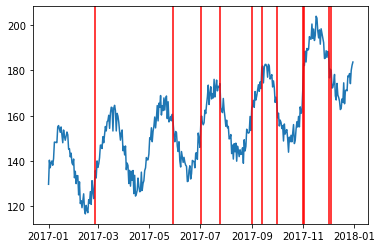

In [19]:
det = BOCPDetector(tsd)
changepoint = det.detector(threshold=0.7)
det.plot(changepoint);

The main assumption with a model that has a good fit is that the residuals are gaussian distributed. This is the same assumption that holds for bayesian changepoint detection. The residuals can be used to detect whether the model (*not the data*) is drifting. This can be due to drift in the data or other causes.

c:\Users\chidi\anaconda3\envs\dbconnect\lib\site-packages\ax\core\parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

c:\Users\chidi\anaconda3\envs\dbconnect\lib\site-packages\ax\core\parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



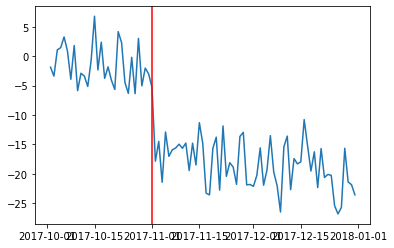

In [16]:
det = BOCPDetector(tsdPred);
changepoint = det.detector(threshold=0.7);
det.plot(changepoint);